In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_dir = './data/train512/'
test_dir = './data/test512/'0.06041

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,name,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,ID_63eb1e259,0,0,0,0,0,0
1,ID_2669954a7,0,0,0,0,0,0
2,ID_52c9913b1,0,0,0,0,0,0
3,ID_4e6ff6126,0,0,0,0,0,0
4,ID_7858edd88,0,0,0,0,0,0


In [5]:
print('Epidural: ',np.sum(df['epidural']))
print('Intraparenchymal: ',np.sum(df['intraparenchymal']))
print('Intraventricular: ',np.sum(df['intraventricular']))
print('Subarachnoid: ',np.sum(df['subarachnoid']))
print('Subdural: ',np.sum(df['subdural']))
print('Any: ',np.sum(df['any']))

Epidural:  2761
Intraparenchymal:  32564
Intraventricular:  23766
Subarachnoid:  32122
Subdural:  42496
Any:  97103


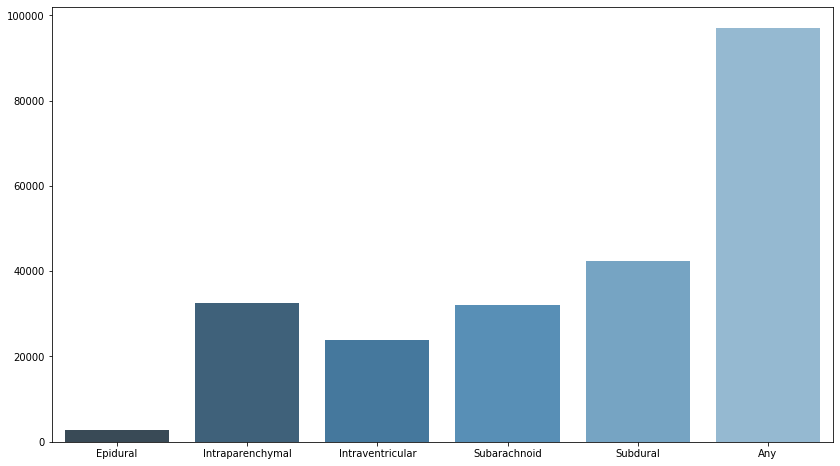

In [8]:
#plt.hist(['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural','Any'], [np.sum(df['epidural']),np.sum(df['intraparenchymal']),np.sum(df['intraventricular']),np.sum(df['subarachnoid']),np.sum(df['subdural']),np.sum(df['any'])])
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(
    x=['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural','Any'],
    y=[np.sum(df['epidural']),np.sum(df['intraparenchymal']),np.sum(df['intraventricular']),np.sum(df['subarachnoid']),np.sum(df['subdural']),np.sum(df['any'])],
    ax=ax,
    palette="Blues_d"
)

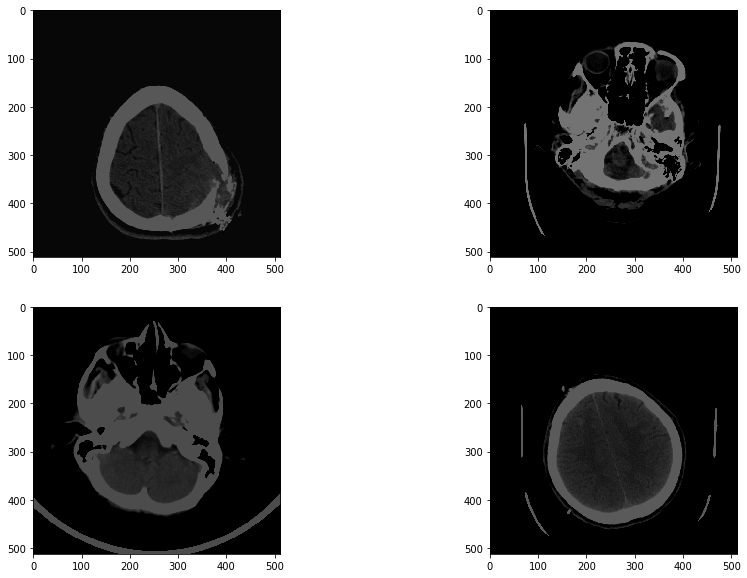

In [10]:
fig=plt.figure(figsize=(15, 10))
columns = 2; rows = 2
for i in range(1, columns*rows +1):
    ds = cv2.imread(train_dir + df.loc[i]['name']+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds, cmap=plt.cm.bone)
    fig.add_subplot

In [60]:
import pandas as pd

In [61]:
df = pd.read_csv('train2.csv')
df.head()

,name,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,ID_12cadc6af,0,0,0,0,0,0
1,ID_38fd7baa0,0,0,0,0,0,0
2,ID_6c5d82413,0,0,0,0,0,0
3,ID_aec8e68b3,0,0,0,1,0,1
4,ID_4d9209c7c,0,0,0,0,0,0


In [62]:
submit = pd.read_csv('./submission/submission_b4_tta.csv')
train2 = pd.read_csv('stage_2_train.csv')

In [63]:
compare = pd.merge(train2, submit, on=['ID'], how='inner')

In [64]:
import numpy as np

In [65]:
true = np.array(compare['Label_x'].tolist())
logits = np.array(compare['Label_y'].tolist())

In [66]:
from sklearn.metrics import log_loss
log_loss(true, logits)

0.0840671603002624

In [36]:
print(sklearn.__version__)

0.21.3


In [ ]:

for threshold in range(64,66,1):
    threshold /= 100
    c_matrix = 0
    for idx, (images,targets) in tqdm(enumerate(val_loader), total=len(val_loader)):
        logits = torch.sigmoid(model(images.cuda()))
        for i, logit in enumerate(logits):
            c_matrix += confusion_matrix(logit, targets[i].cuda(),threshold=threshold)[0]

    precision = c_matrix[0] / (c_matrix[0] + c_matrix[1])
    recall = c_matrix[0] / (c_matrix[0] + c_matrix[2])
    precision = precision.detach().cpu().numpy()
    recall = recall.detach().cpu().numpy()
    results.append([
        threshold,
        (precision[0], recall[0]),
        (precision[1], recall[1]),
        (precision[2], recall[2]),
        (precision[3], recall[3]),
        (precision[4], recall[4]),
        (precision[5], recall[5])
    ]
    )
    print('Precision: ',precision)
    print('Recall: ',recall)

In [1]:
import os
b=os.listdir('./stage2/train512')
len(b)

752802

In [9]:
f= lambda x: x.split('.')[0]
c = [f(i) for i in b]

In [10]:
import pandas as pd
b_ = pd.DataFrame(c,columns=['name'])

In [16]:
len(b_)

752802

In [2]:
import pandas as pd
a = pd.read_csv('train2.csv')
len(a)

752807

In [20]:
a_ = a.drop([9391, 195305,617552,640413])

In [25]:
a__ = a_.reset_index()

In [27]:
a__[a__['name'] == 'ID_6431af929']

,index,name,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
451013,451015,ID_6431af929,0,0,0,0,0,0


In [32]:
e = a__.drop([451013])

In [36]:
e_ = e.reset_index().drop(columns=['level_0', 'index'])

In [41]:
e_.to_csv('train2.csv',index=False)

In [13]:
mergedStuff = pd.merge(a, b_, on=['name'], how='inner')
len(mergedStuff)

752806

In [11]:
c = a['name'].tolist()

In [14]:
b[0]

'ID_cf7c1703e.png'

In [ ]:
from tqdm import tqdm
tmp = []
for i in tqdm(c, total=len(c)):
    if (i+'.png') not in b:
        tmp.append(i+'.png')


 45%|████▌     | 340055/752807 [25:45<32:15, 213.23it/s] 

In [21]:
len(tmp)

1393

In [22]:
tmp[0]

'ID_d8c60df9e.png'

In [38]:
with open('missing.txt', 'w') as f:
    for item in tmp:
        f.write("%s\n" % item)

In [39]:
lineList = [line.rstrip('\n') for line in open('missing.txt','r')]
f = lambda x: x.replace('.png','.dcm')
res = [f(i) for i in lineList]

In [44]:
f = lambda x: x.replace('.png','.dcm')

In [45]:
res = [f(i) for i in lineList]

In [47]:
len(res)

1393